# Mobile Price Classification

### Данный дата сет представляет собой набор характеристик соврменнных смартфонов. 
https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification/

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_frame = pd.read_csv("test.csv")

In [20]:
selected_columns = ['id','battery_power','clock_speed','fc','int_memory','mobile_wt']
df = data_frame[selected_columns].sort_values(by='id', ascending=True)

In [21]:
# Добавление нового признака для каждого из существующих признаков
df['cvi'] = (df['battery_power'] * df['clock_speed']) / df['int_memory']
df

,id,battery_power,clock_speed,fc,int_memory,mobile_wt,cvi
0,1,1043,1.8,14,5,193,375.480000
1,2,841,0.5,4,61,191,6.893443
2,3,1807,2.8,1,27,186,187.392593
3,4,1546,0.5,18,25,96,30.920000
4,5,1434,1.4,11,49,108,40.971429
...,...,...,...,...,...,...,...
995,996,1700,1.9,0,54,170,59.814815
996,997,609,1.8,0,13,186,84.323077
997,998,1185,1.4,1,8,80,207.375000
998,999,1533,0.5,0,50,171,15.330000


In [22]:
# Удаление выбросов
Q1 = data_frame[selected_columns].quantile(0.25)
Q3 = data_frame[selected_columns].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[selected_columns] < (Q1 - 1.5 * IQR)) | (df[selected_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [23]:
# УДАЛЕНИЕ ДУБЛЕЙ
df = df.drop_duplicates()

# Обработка пропущенных значений
df = df.fillna(df.mean())

# Обнаружение кривых данных
from scipy import stats
z_scores = np.abs(stats.zscore(df[selected_columns]))
df = df[(z_scores < 3).all(axis=1)]

# Сброс индексов
df.reset_index(drop=True, inplace=True)

df

,id,battery_power,clock_speed,fc,int_memory,mobile_wt,cvi
0,1,1043,1.8,14,5,193,375.480000
1,2,841,0.5,4,61,191,6.893443
2,3,1807,2.8,1,27,186,187.392593
3,5,1434,1.4,11,49,108,40.971429
4,6,1464,2.9,5,50,198,84.912000
...,...,...,...,...,...,...,...
981,996,1700,1.9,0,54,170,59.814815
982,997,609,1.8,0,13,186,84.323077
983,998,1185,1.4,1,8,80,207.375000
984,999,1533,0.5,0,50,171,15.330000


## Построение графиков:


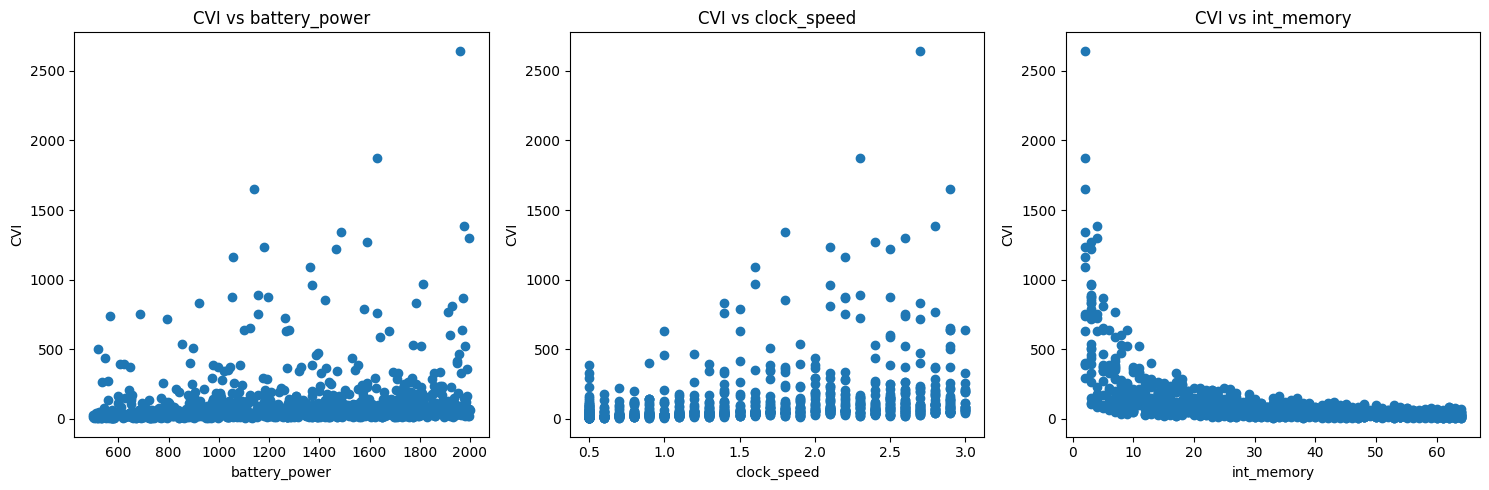

In [24]:
import matplotlib.pyplot as plt

# Создаем подграфики
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# График зависимости CVI от battery_power
axes[0].scatter(df['battery_power'], df['cvi'])
axes[0].set_title('CVI vs battery_power')
axes[0].set_xlabel('battery_power')
axes[0].set_ylabel('CVI')

# График зависимости CVI от clock_speed
axes[1].scatter(df['clock_speed'], df['cvi'])
axes[1].set_title('CVI vs clock_speed')
axes[1].set_xlabel('clock_speed')
axes[1].set_ylabel('CVI')

# График зависимости CVI от int_memory
axes[2].scatter(df['int_memory'], df['cvi'])
axes[2].set_title('CVI vs int_memory')
axes[2].set_xlabel('int_memory')
axes[2].set_ylabel('CVI')

# Регулировка макета
plt.tight_layout()

# Показываем графики
plt.show()

Исследование зависимости между быстротой
На графике  CVI vs int_memory мы видим огромный кластер(0-400), где значения относительно
равномерно распределены. На мой взгляд на показатель CVI количество памяти не влият, а
только clock_speed и battery power.

## Визуальный анализ кластеров

Text(0, 0.5, 'Инерция')

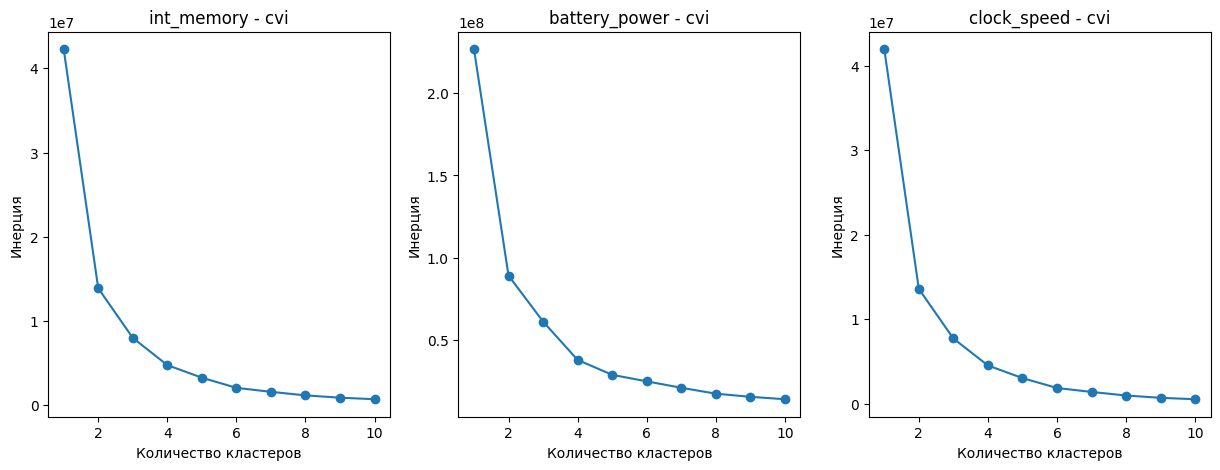

In [25]:
from sklearn.cluster import KMeans

# для определения количества числа кластеров используем метод локтя
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Вычисление инерции для разного числа кластеров
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(df[['int_memory', 'cvi']])
    inertia.append(kmeans.inertia_)

# Построение графика "локтя"
axes[0].plot(range(1, 11), inertia, marker='o')
axes[0].set_title('int_memory - cvi')
axes[0].set_xlabel('Количество кластеров')
axes[0].set_ylabel('Инерция')

#
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(df[['battery_power', 'cvi']])
    inertia.append(kmeans.inertia_)
axes[1].plot(range(1, 11), inertia, marker='o')
axes[1].set_title('battery_power - cvi')
axes[1].set_xlabel('Количество кластеров')
axes[1].set_ylabel('Инерция')

#
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(df[['clock_speed', 'cvi']])
    inertia.append(kmeans.inertia_)
axes[2].plot(range(1, 11), inertia, marker='o')
axes[2].set_title('clock_speed - cvi')
axes[2].set_xlabel('Количество кластеров')
axes[2].set_ylabel('Инерция')

# как видно по построенным графикам, оптимальное количество кластеров для каждого рассматриваемого случая - 3

## Применение метода KMeans:

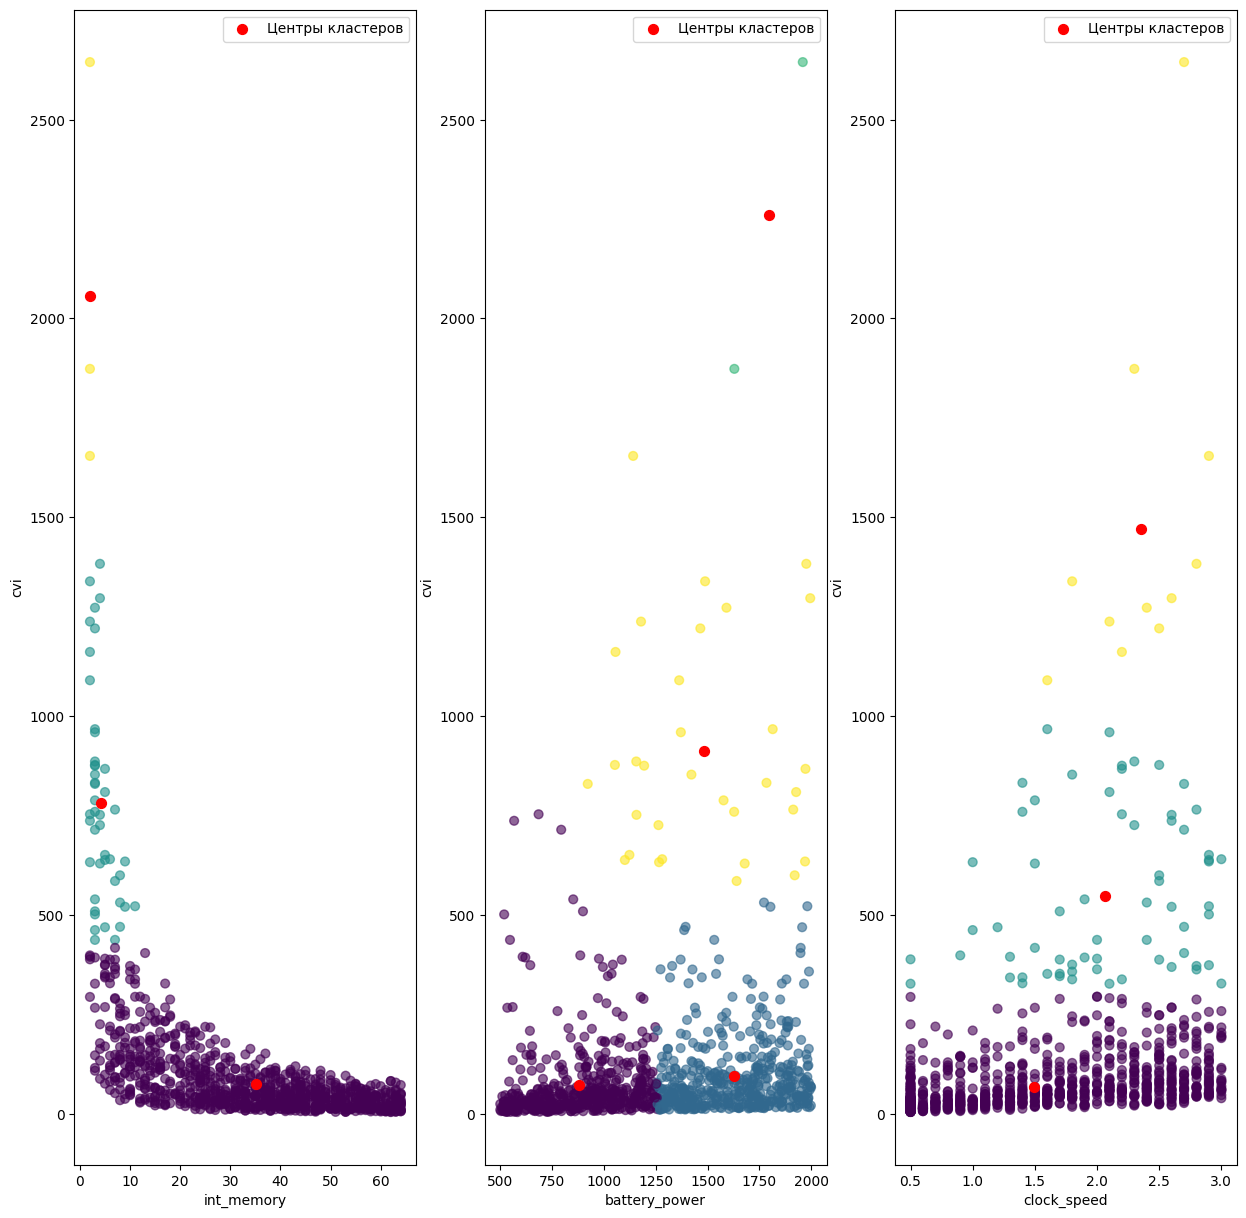

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df[['int_memory', 'cvi']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_

axes[0].scatter(df['int_memory'], df['cvi'], c=labels, cmap='viridis', s=40, alpha=0.6)
axes[0].scatter(centers[:, 0], centers[:, 1], c='red', marker='.', s=200, label='Центры кластеров')
axes[0].set_xlabel('int_memory')
axes[0].set_ylabel('cvi')
axes[0].legend()

#
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(df[['battery_power', 'cvi']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_

axes[1].scatter(df['battery_power'], df['cvi'], c=labels, cmap='viridis', s=40, alpha=0.6)
axes[1].scatter(centers[:, 0], centers[:, 1], c='red', marker='.', s=200, label='Центры кластеров')
axes[1].set_xlabel('battery_power')
axes[1].set_ylabel('cvi')
axes[1].legend()

#
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df[['clock_speed', 'cvi']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_

axes[2].scatter(df['clock_speed'], df['cvi'], c=labels, cmap='viridis', s=40, alpha=0.6)
axes[2].scatter(centers[:, 0], centers[:, 1], c='red', marker='.', s=200, label='Центры кластеров')
axes[2].set_xlabel('clock_speed')
axes[2].set_ylabel('cvi')
axes[2].legend()


## Вывод
Добавление новых атрибутов к данным предоставляет уникальную возможность обогатить информацию, что способствует более глубокому и всестороннему пониманию данных для последующего анализа.

Этап "причесывания" датасета представляет собой ключевой этап предварительной обработки данных. Этот этап играет важную роль в улучшении качества данных и предотвращении возможных искажений, которые могут возникнуть в процессе анализ.

Построение графиков является важным инструментом для выявления визуальных зависимостей и выделения кластеров в данных. Это позволяет более наглядно представить структуру данных и выделить важные закономерноти.

Использование метода KMeans предоставляет дополнительные возможности для анализа данных. Этот метод позволяет выделить и более детально изучить характеристики формируемых кластеров, что способствует более глубокому пониманию структуры данных. области.